In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import ipyparallel as ipp
from ipyparallel.error import TimeoutError

rc = ipp.Client(profile="default")
view = rc[:]
view.block = True

In [2]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [3]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

[stdout:0] MPI rank: 0/1
[stdout:1] MPI rank: 0/1
[stdout:2] MPI rank: 0/1
[stdout:3] MPI rank: 0/1
[stdout:4] MPI rank: 0/1
[stdout:5] MPI rank: 0/1
[stdout:6] MPI rank: 0/1
[stdout:7] MPI rank: 0/1


In [4]:
ranks = view['rank']
rank_indices = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in rank_indices]

In [5]:
%%px

stop = False
nsteps = 100
delay = 0.1

xmin, xmax = 0, np.pi
ymin, ymax = 0, 2*np.pi
dy = (ymax-ymin)/mpi.size

def simulation():
    """Toy simulation code, computes sin(f*(x**2+y**2)) for a slowly increasing f
    over an increasingly fine mesh.

    The purpose of this code is simply to illustrate the basic features of a typical
    MPI code: spatial domain decomposition, a solution which is evolving in some 
    sense, and local per-node computation.  In this case the nodes don't really
    communicate at all.
    """
    # By making these few variables global, we allow the IPython client to access them
    # remotely for interactive introspection
    global j, Z, nx, nyt
    freqs = np.linspace(0.6, 1, nsteps)
    for j in range(nsteps):
        nx, ny = 2+j/4, 2+j/2/mpi.size
        nyt = mpi.size*ny
        Xax = np.linspace(xmin, xmax, nx)
        Yax = np.linspace(ymin+rank*dy, ymin+(rank+1)*dy, ny, endpoint=rank==mpi.size)
        X, Y = np.meshgrid(Xax, Yax)
        f = freqs[j]
        Z = np.cos(f*(X**2 + Y**2))
        # We add a small delay to simulate that a real-world computation
        # would take much longer, and we ensure all nodes are synchronized
        time.sleep(delay)
        # The stop flag can be set remotely via IPython, allowing the simulation to be
        # cleanly stopped from the outside
        if stop:
            break

In [6]:
from IPython.display import clear_output

def plot_current_results(in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    
    # We make a blocking call to load the remote data from the simulation into simple named 
    # variables we can read from the engine namespaces
    #view.apply_sync(load_simulation_globals)
    # And now we can use the view to read these variables from all the engines.  Then we
    # concatenate all of them into single arrays for local plotting
    try:
        Z = np.concatenate(mpi_order(view['Z']))
    except ValueError:
        print("dimension mismatch in Z, not plotting")
        ax = plt.gca()
        return ax.figure
        
    nx, nyt, j, nsteps = view.pull(['nx', 'nyt', 'j', 'nsteps'], targets=0)
    fig, ax = plt.subplots()
    ax.contourf(Z)
    ax.set_title('Mesh: %i x %i, step %i/%i' % (nx, nyt, j+1, nsteps))
    plt.axis('off')
    # We clear the notebook output before plotting this if in-place plot updating is requested
    if in_place:
        clear_output(wait=True)
    display(fig)
    return fig

In [7]:
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    return any(view.apply_sync(lambda : simulation_thread.is_alive()))

In [8]:
def monitor_simulation(refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if not simulation_alive():
        plot_current_results(in_place=plots_in_place)
        plt.close('all')
        print('Simulation has already finished, no monitoring to do.')
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():
            fig = plot_current_results(in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt, TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output(wait=True)
        plt.close('all')
        display(fig)
    print(msg)
    print('Monitored for: %s.' % tmon)

In [9]:
%%px
from threading import Thread
stop = False
nsteps = 100
delay=0.5
# Create a thread wrapper for the simulation. The target must be an argument-less
# function so we wrap the call to 'simulation' in a simple lambda:
simulation_thread = Thread(target = lambda : simulation())
# Now we actually start the simulation
simulation_thread.start()

[stderr:0] 
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
[stderr:1] 
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
[stderr:2] 
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:26: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/opt/conda/lib/python3.6/site-packages/ipyparallel/engine/__main__.py:27: DeprecationWarning: object of type <class 'fl

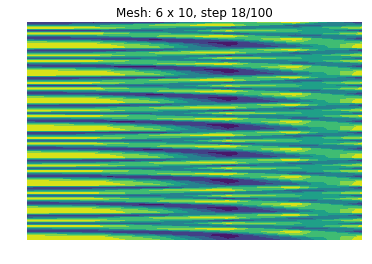

In [ ]:
monitor_simulation(refresh=2);

In [ ]:
#view['stop'] = True

In [ ]:
%%px --target 0
from ipyparallel import bind_kernel; bind_kernel()
%connect_info

In [ ]:


%%px --target 0
%qtconsole

